<a href="https://colab.research.google.com/github/ThanhDung2003/Beginners-code/blob/main/Copy_of_Detect_misalignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Libraries

In [ ]:
# Pip install method (recommended)
!pip install ultralytics==8.0.196

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 3.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/MyDrive/ThankZung"

Mounted at /content/gdrive
'Copy of 001_TayNinh_MitMot_20230325063157_20230325113256_000037_jpg.rf.5d9aaec9cab209ab7aa4561031b7bf68.jpg'
 Detec_misalignment.v1i.yolov8.zip
 results_model2
'tnh-label (1).rar'
 vehicle-counting.mp4
 vehicle-counting-result.mp4
 video-detect-20240425T012128Z-001.zip


Dung: Load video, nhận diện, lưu video sau nhận diện với model gốc

## Imports

In [ ]:
import ultralytics
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.8/78.2 GB disk)


In [ ]:
#load models
# MODEL = "yolov8x.pt"
MODEL = "/content/gdrive/MyDrive/ThankZung/results_model2/weights/last.pt"

In [ ]:
model = YOLO(MODEL)

## Train model mới bằng v8/v9 với bộ dataset hiện tại
Deadline:  T2 25/03/2024
- Dung: Train thử nghiệm với dataset

In [ ]:
img = cv2.imread('/content/001_TayNinh_MitMot_20230325063157_20230325113256_000001.jpg')
results = model.predict(img)


0: 480x640 3 Cars, 11 Motorbikes, 1 Truck, 73.3ms
Speed: 2.7ms preprocess, 73.3ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


In [ ]:
#Kiểm tra điểm nằm bên trái đường thẳng
def check_left_line(segment1, x, y):
  a = (segment1[3] - segment1[1]) / (segment1[2] - segment1[0])
  b = segment1[1] - a * segment1[0]
  if x < (y - b)/a:
    return 1
  else:
    return 0

In [ ]:
#Kiểm tra điểm nằm bên trong vùng
def check_in_region(segment1, x, y):
  a = (segment1[3] - segment1[1]) / (segment1[2] - segment1[0])
  b = segment1[1] - a * segment1[0]
  if y < a * x + b:
    return 1
  else:
    return 0

In [ ]:
def check_inside_lane(segment1, segment2, x, y):
  A_xStart, A_yStart, A_xEnd, A_yEnd = segment1
  B_xStart, B_yStart, B_xEnd, B_yEnd = segment2
  if min(A_yEnd, A_yEnd) < y < max(A_yEnd, A_yEnd) and \
     min(B_yEnd, B_yEnd) < y < max(B_yEnd, B_yEnd) and \
     min(A_xStart, A_xEnd) < x < max(A_xStart, A_xEnd) and \
     min(B_xStart, B_xEnd) < x < max(B_xStart, B_xEnd):
     return 1
  else:
     return 0

In [ ]:
def check_right_lane(segments, x, y, cl):
    # check_inside_lanes = False
    # Số đoạn thẳng mà điểm phải nằm bên trái để được coi là nằm trong lane đường
    left_count = 0

    # Kiểm tra điểm nằm trong vùng lane
    # for i in range(len(segments) - 1):
    #   segment1 = segments[i]
    #   segment2 = segments[i + 1]
    # # Nếu điểm nằm trong đoạn thẳng
    #   check_inside_lanes = check_inside_lane(segment1, segment2, x, y)

    # Nếu đoạn thẳng nằm bên trái của điểm
    # if check_inside_lanes == True:
    for segment in segments:
      if check_left_line(segment, x, y) & check_in_region (segment, x, y):
        left_count += 1

    #Kiểm tra xem điểm có nằm trong lane đường không
    if (left_count == 1 or left_count == 6) and (cl == 3 or cl == 0): return 1
    elif (left_count == 2 or left_count == 5) and (cl == 5 or cl == 1): return 1
    elif (left_count == 3 or left_count == 4) and cl == 2: return 1
    else: return 0

In [ ]:
results[0].boxes[0].cls.item()

3.0

results: ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Bike', 1: 'Bus', 2: 'Car', 3: 'Motorbike', 4: 'Truck'}
orig_img: array([[[243, 252, 255],
        [243, 252, 255],
        [243, 252, 255],
        ...,
        [237, 234, 236],
        [237, 234, 236],
        [237, 234, 236]],

       [[243, 252, 255],
        [243, 252, 255],
        [243, 252, 255],
        ...,
        [237, 234, 236],
        [237, 234, 236],
        [237, 234, 236]],

       [[243, 252, 255],
        [243, 252, 255],
        [243, 252, 255],
        ...,
        [237, 234, 236],
        [237, 234, 236],
        [237, 234, 236]],

       ...,

       [[ 41,  40,  42],
        [ 41,  40,  42],
        [ 41,  40,  42],
        ...,
        [ 81,  81,  87],
        [ 83,  83,  89],
        [ 82,  82,  88]],

       [[ 39,  41,  42],
        [ 39,  41,  42],
        [ 39,  41,  42],
        ...,
        [ 81,  81,

<ipython-input-78-ac00a7e74de5>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cv2.putText(img, str(int(cls)), (int(bb[0]), int(bb[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,255,0), 2, cv2.LINE_AA)
<ipython-input-78-ac00a7e74de5>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if check_right_lane(V_array, mid, bb[3], int(cls)):


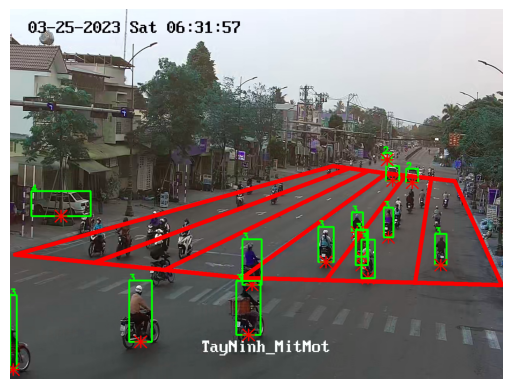

In [ ]:
print('results:', results[0])
for r in results:
  for box in r.boxes.cpu().numpy():
    bb = box.xyxy[0]  # get box coordinates in (left, top, right, bottom) format
    cls = box.cls
    print(f"Class: {cls} - Coordinates: {bb} - Type: {type(bb)}")
    mid = (bb[0]+bb[2])/2
    M = (int(mid), int(bb[3]))
    cv2.rectangle(img,(int(bb[0]),int(bb[1])),(int(bb[2]),int(bb[3])),(0,255,0),3)
    cv2.putText(img, str(int(cls)), (int(bb[0]), int(bb[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,255,0), 2, cv2.LINE_AA)
    print("Midpoint: ", mid, bb[3])
    if check_right_lane(V_array, mid, bb[3], int(cls)):
      print("Điểm M nằm trong lane đường.")
    else:
      print("Điểm M không nằm trong lane đường.")
      cv2.drawMarker(img, M, (250,0,0), cv2.MARKER_STAR, 30, 2, cv2.LINE_AA)
  if cv2.waitKey(1) & 0xFF == ord(' '):
    break

plt.imshow(img)
plt.axis('off')  # Tắt hiển thị trục tọa độ
plt.show()

## DOWNLOAD VIDEO

#Lane Detection & misalignment

- Tạo file txt chứa tọa độ điểm trên ảnh và vẽ line của các lane đường.
- Sử dụng tọa độ tâm của xe để kiểm tra đúng làn, sai làn.


#Draw line

This image is: <class 'numpy.ndarray'> with dimensions: (960, 1280, 3)
(960, 1280, 3)


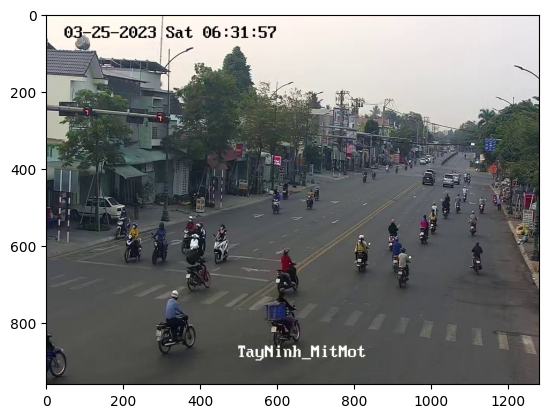

In [ ]:
image = mpimg.imread('/content/001_TayNinh_MitMot_20230325063157_20230325113256_000001.jpg')
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)
#plt.imshow(image, cmap='gray')
print(image.shape)

In [ ]:
def Draw_lane(img, x1, y1, x2, y2):
  img=cv2.line(img, (x1, y1), (x2, y2), (250,0,0),10)
  plt.imshow(img)

V_array [[12, 637, 838, 407], [220, 657, 880, 413], [400, 677, 930, 420], [603, 697, 977, 426], [603, 697, 977, 426], [820, 703, 1024, 434], [1052, 705, 1093, 440], [1277, 716, 1154, 446]]
H_array [[12, 637, 603, 697], [603, 697, 1277, 716], [838, 407, 977, 426], [977, 426, 1154, 446]]


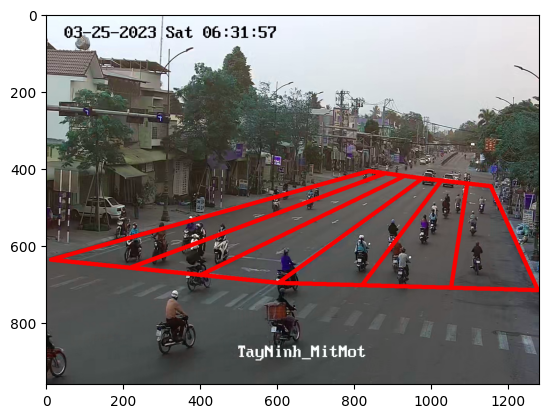

In [ ]:
V_array = []
H_array = []
array_option = 'N'

file_draw_line = open('/content/draw_line - Copy.txt')
data = file_draw_line.readlines()
for line in data:
  if line[0] != "#":
    if line[0] == "@":
        array_option = 'V'
    elif line[0] == "$":
        array_option = 'H'
    else:
      coord_list = list(map(int, line.split()))
      if len(coord_list):
        if(array_option == 'V'):
          V_array.append(coord_list)
        elif(array_option == 'H'):
          H_array.append(coord_list)

print("V_array", V_array)
print("H_array", H_array)

for i in range(len(V_array)):
  Draw_lane(img, V_array[i][0],V_array[i][1],V_array[i][2],V_array[i][3])
for i in range(len(H_array)):
  Draw_lane(img, H_array[i][0],H_array[i][1],H_array[i][2],H_array[i][3])

file_draw_line.close()


# Detect misalignment

Gỉa định bối cảnh:
- Đường 2 chiều:
  +  Chiều xuôi: làn trong cùng là của xe máy, xe đạp, làn giữa là của xe tải, xe bus, làn ngoài cùng là của xe ô tô.
  + Chiều ngược: cũng dị

Gọi I(x,y) là tâm của phương tiện (trung điểm cạnh dưới của bouding box)
- Nếu y < y của các line --> vào vùng cần check
- Nếu x > x của các line --> phương tiện bên phải line
- Nếu x < x của các line --> phương tiện bên trái line.

Step by step:
- Bước 1: Code phân làn.
  + Chia khoảng
- Bước 2: Kiểm tra xe có nằm trong làn hay không.